# Detecting Retina Damage From Optical Coherence Tomography (OCT) Images, using Transfer Learning on VGG16 CNN Model

In [47]:
# !pip install keract
# !pip install tensorflow
# !pip instal matplotlib
# !pip install --upgrade numpy
# !pip install --upgrade tensorflow
# !pip install --upgrade protobuf

## Imports

In [48]:
import os, math
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
import keract
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Conv2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import KFold


In [49]:
# import zipfile
# # Spécifiez le chemin d'accès au fichier zip
# zip_path = 'kermany2018.zip'
# # Ouvrir le fichier zip
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     # Extraire tous les fichiers du zip dans le répertoire actuel
#     zip_ref.extractall()

In [50]:
# creation des dossiers du model
model_name = 'vgg16_e10b64_7'
# creation du dossier du modèle
if not os.path.exists(model_name):
   os.makedirs(model_name)
if not os.path.exists(model_name+'/img'):
   os.makedirs(model_name+'/img')

## Variables

In [51]:
# définition des variables
numepochs = 5
batch_size = 128
img_width, img_height = 150, 150 
channels = 3

## Dataset

In [52]:
data_dir = "../data/OCT2017/"
train_data_dir= '../data/OCT2017/train/'
val_data_dir= '../data/OCT2017/val/'
test_data_dir= '../data/OCT2017/test/'

In [53]:
# returns a dataframe from dataset path
def create_dataframe(path) : 

   categories = os.listdir(path)
   print(f"Types of classes found: {len(categories)}")

   files = []

   # Get all the file names
   for cat in categories:
      all_data = os.listdir(path+cat)
      
      # Add them to the list
      for data in all_data:
         files.append((cat, str(path +cat) + '/' + data))

   df = pd.DataFrame(data=files, columns=['classe', 'image'])

   # Let's check how many samples for each category are present
   print(f"Total number of images in the dataset: {len(df)}")
   print(f"Images in each classe: \n{df['classe'].value_counts()}")
   
   return df

In [54]:
# Build a train dataframe        
train_df = create_dataframe(train_data_dir)

Types of classes found: 4
Total number of images in the dataset: 83484
Images in each classe: 
CNV       37205
NORMAL    26315
DME       11348
DRUSEN     8616
Name: classe, dtype: int64


In [55]:
# Build a val dataframe        
val_df = create_dataframe(val_data_dir)

Types of classes found: 4
Total number of images in the dataset: 32
Images in each classe: 
CNV       8
DME       8
DRUSEN    8
NORMAL    8
Name: classe, dtype: int64


In [56]:
# Build a test dataframe        
test_df = create_dataframe(test_data_dir)

Types of classes found: 4
Total number of images in the dataset: 968
Images in each classe: 
CNV       242
DME       242
DRUSEN    242
NORMAL    242
Name: classe, dtype: int64


In [57]:
# df = pd.concat([train_df, val_df, test_df])
# df['classe'].value_counts()

In [58]:
def show_labels_counts(labels, counts, suffixe):
    plt.rcParams['figure.figsize'] = (8.0, 8.0)
    plt.bar(labels, counts, color=['tab:red', 'tab:green', 'tab:blue', 'tab:orange'])
    plt.axis('on')
    plt.xlabel("Labels") 
    plt.ylabel("Count")
    plt.title('Data distribution per class\n')
    plt.savefig(f'{model_name}/img/labels_vs_counts_{suffixe}.png', transparent= False, bbox_inches= 'tight', dpi= 400)
    plt.show() 

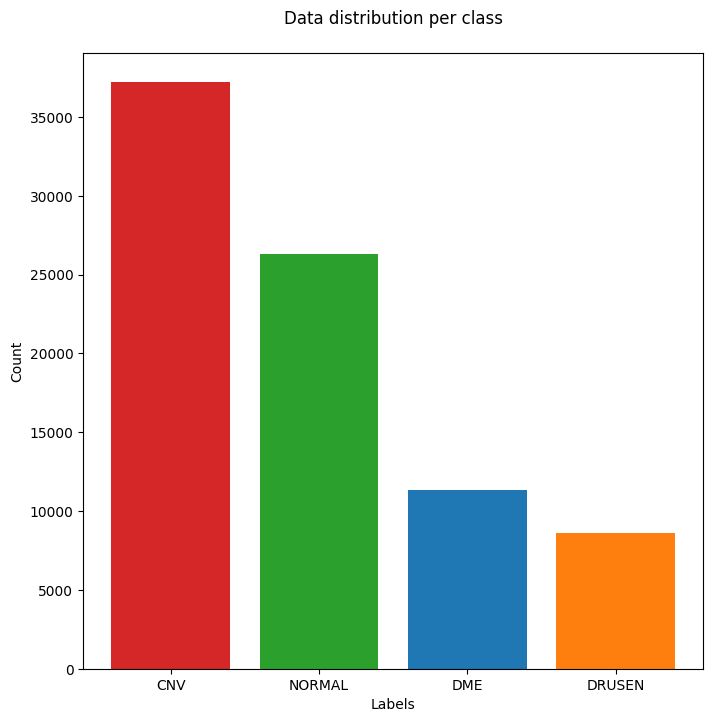

In [59]:
train_counts = train_df['classe'].value_counts()
labels = list(train_counts.index)
counts = list(train_counts.values)
show_labels_counts(labels, counts, 'before balance')

## Equilibrage des données

In [60]:
train_df.classe.value_counts()

CNV       37205
NORMAL    26315
DME       11348
DRUSEN     8616
Name: classe, dtype: int64

In [61]:
normal_df = train_df.loc[train_df.classe == 'NORMAL']
normal_count = normal_df.shape[0]
normal_count

26315

In [62]:
def balanced_category_df(df, category, value):
    balanced_df = pd.DataFrame()
    n = math.ceil((value-df.classe.value_counts()[category])/df.classe.value_counts()[category])
    cat_df = df.loc[df.classe == category]
    if n > 1 :
        balanced_df = cat_df.loc[cat_df.index.repeat(n)]
    elif n < 1 :
        balanced_df = df.loc[df.classe == category].sample(n=value, axis=0)
    else :
        balanced_df = df.loc[df.classe == category]
    print(f"{category} new count : {balanced_df['classe'].value_counts()[category]}")
    return balanced_df

In [63]:
drusen_df = balanced_category_df(train_df, 'DRUSEN', normal_count)
dme_df = balanced_category_df(train_df, 'DME', normal_count)
cnv_df = balanced_category_df(train_df, 'CNV', normal_count)

DRUSEN new count : 25848
DME new count : 22696
CNV new count : 26315


In [64]:
balanced_train_df = pd.concat([drusen_df, dme_df, cnv_df, normal_df])

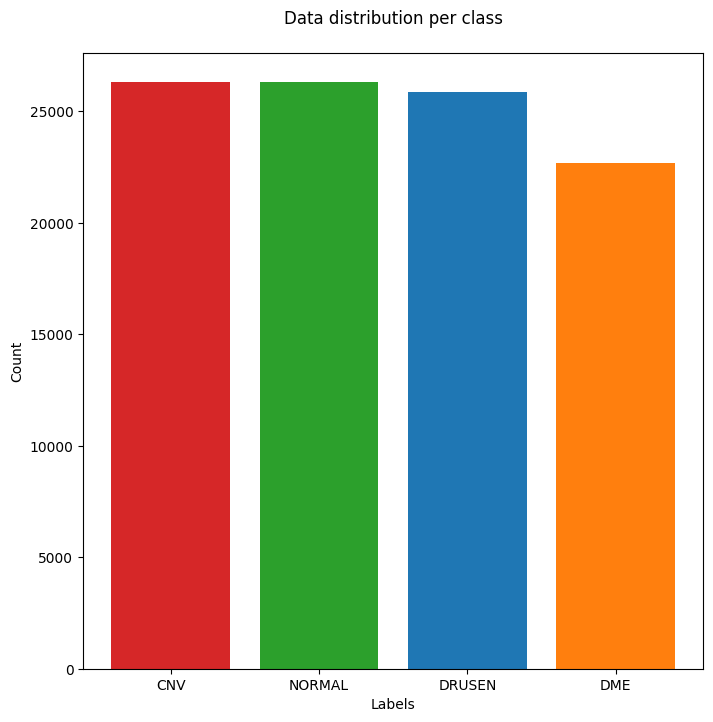

In [65]:
train_counts = balanced_train_df['classe'].value_counts()
labels = list(train_counts.index)
counts = list(train_counts.values)
show_labels_counts(labels, counts, 'after_balance')

## Model

### Transfert learning

* VGG16 CNN architecture is used for classification.
* Pretrained on the 'ImageNet' dataset.

In [66]:
# instanciation d'un model VGG16 avec pré-entrainement imagenet
vgg16 = VGG16(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [67]:
# creation du model avec transfert learning de vgg16 et ajout de couches de sortie
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

# Ajout de la couche de max pooling
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='block6_conv1'))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='block6_conv2'))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='block6_conv3'))
# Ajout de la couche de max pooling
model.add(MaxPooling2D(pool_size=(2, 2), name='block6_pool'))

# Ajout de la couche d'aplatissement
model.add(Flatten(name='flatten_1'))

# Ajout de la couche entièrement connectée
model.add(Dense(1024, activation='relu', name='dense_1'))

# Ajout de la couche de dropout
model.add(Dropout(0.4, name='dropout_4'))

# Ajout de la deuxième couche entièrement connectée
model.add(Dense(1024, activation='relu',name='dense_2'))

# Ajout de la deuxième couche de dropout
model.add(Dropout(0.2, name='dropout_2'))

# Ajout de la couche de sortie
model.add(Dense(4, activation='softmax', name='dense_3'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)      

### Baseline Model Training

In [68]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)
valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
)

# Définir le nombre de plis pour la validation croisée
k = 5

# Créer un objet KFold
kf = KFold(n_splits=k)

In [69]:

# Effectuer la validation croisée
for train_index, val_index in kf.split(train_df):
    # Diviser les données en plis d'entraînement et de validation
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]

    # encodage des catégories
    num_classes = len(labels)  

    # augmentation de données sur le pli d'entraînement
    train_generator = train_datagen.flow_from_dataframe(
        train_fold,
        x_col='image',
        y_col='classe',
        target_size=(img_width, img_height),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=1337
    )
    # encodage des catégories
    train_labels = train_generator.classes
    train_labels = to_categorical(train_labels, num_classes=num_classes)
    nb_train_samples = len(train_generator.filenames)
    print(f'train set : {nb_train_samples}')

    # augmentation de données sur le pli de validation
    val_generator = valid_datagen.flow_from_dataframe(
        val_fold,
        x_col='image',
        y_col='classe',
        target_size=(img_width, img_height),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=1337
    )
    # encodage des catégories
    valid_labels = val_generator.classes
    valid_labels = to_categorical(valid_labels, num_classes=num_classes)
    nb_valid_samples = len(val_generator.filenames)
    print(f'validation set : {nb_valid_samples}')

    # compilation du model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # sauvegarde du model
    checkpoint_filepath = model_name + '/tmp/checkpoint'
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    # arrêt anticipé
    earlystop = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=1
    )

    # fonction pour réduire le taux d'apprentissage progressivement
    def learning_rate_scheduler(epoch, lr):
        if epoch % 10 == 0 and epoch > 0:
            lr = lr * 0.5  # Réduction du taux d'apprentissage de moitié
        return lr
    lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

    callbacks_list = [earlystop, checkpoint, lr_scheduler]

    # entrainement du model
    history = model.fit(
        train_generator,
        epochs=numepochs,
        batch_size=batch_size,
        validation_data=val_generator,
        verbose=1,
        callbacks=callbacks_list
    )


Found 66787 validated image filenames belonging to 4 classes.
train set : 66787
Found 16697 validated image filenames belonging to 1 classes.
validation set : 16697
Epoch 1/5
  1/522 [..............................] - ETA: 2:57:06 - loss: 1.4612 - accuracy: 0.1328

KeyboardInterrupt: 

### Evaluations on Test Dataset

In [ ]:
# instanciation de generateurs de données de test 
test_datagen = ImageDataGenerator(
    rescale= 1./255, 
)
test_generator = test_datagen.flow_from_dataframe(  
    test_df,
    x_col='image',
    y_col='classe',
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)
nb_test_samples = len(test_generator.filenames)
print(f'test set : {nb_test_samples}')

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

16/16 [==============================] - 80s 5s/step - loss: 0.3899 - accuracy: 0.9267
Test Loss:  0.3898624777793884
Test Accuracy:  0.9266529083251953


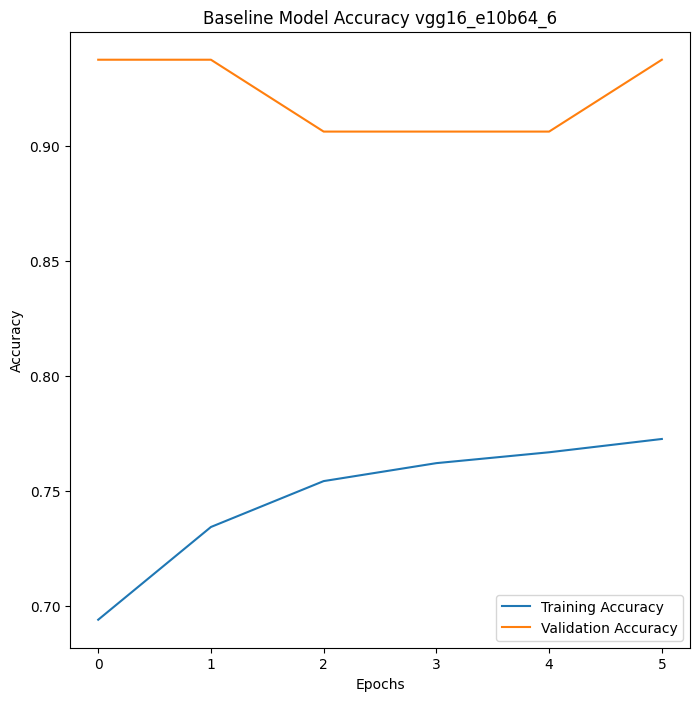

In [ ]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title(f'Baseline Model Accuracy {model_name}')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig(model_name+'/img/baseline_acc_epoch_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

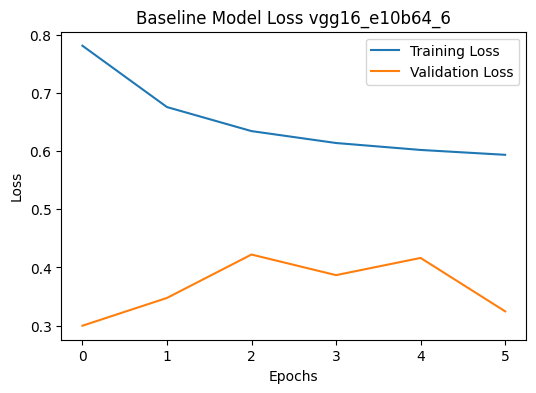

In [ ]:
plt.subplot()
plt.title(f'Baseline Model Loss {model_name}')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig(model_name+'/img/baseline_loss_epoch_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

16/16 [==============================] - 77s 5s/step


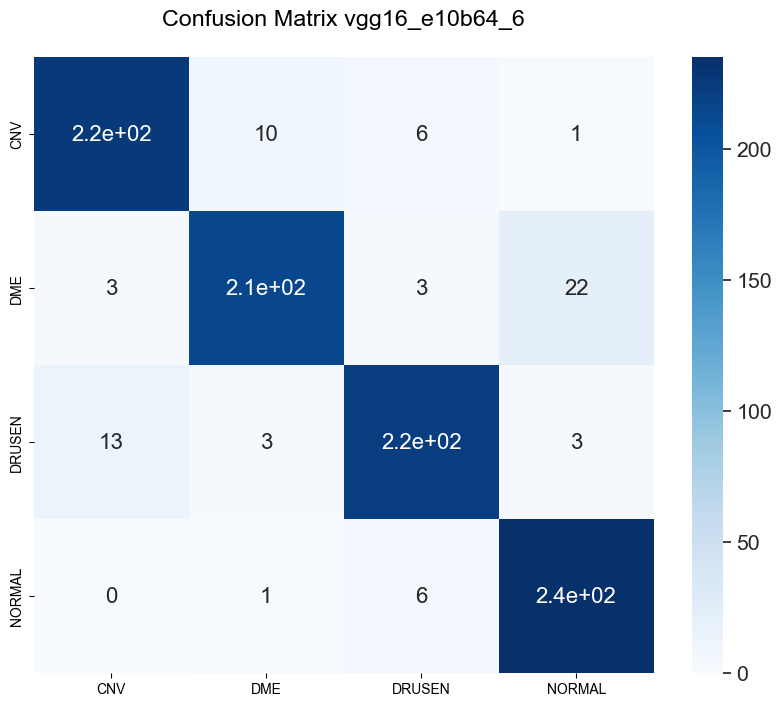

In [ ]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix {model_name}\n')
plt.savefig(model_name+'/img/confusion_matrix_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

In [ ]:
print(f'Classification Report {model_name}\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report vgg16_e10b64_6

              precision    recall  f1-score   support

         CNV       0.93      0.93      0.93       242
         DME       0.94      0.88      0.91       242
      DRUSEN       0.94      0.92      0.93       242
      NORMAL       0.90      0.97      0.93       242

    accuracy                           0.93       968
   macro avg       0.93      0.93      0.93       968
weighted avg       0.93      0.93      0.93       968



### Save the model

In [ ]:
model_save_h5 = model_name+"/retinal_oct_model_"+model_name+".h5"
model_save_json = model_name+"/retinal_oct_model_"+model_name+".json"
model_save_weights = model_name+"/retinal_oct_model_"+model_name+"_weights.h5"
model_save_metrics = model_name+"/retinal_oct_model_"+model_name+"_eval.json"

In [ ]:
# save model and architecture to h5 file
model.save(model_save_h5)
print("Saved h5 model to disk")

Saved h5 model to disk


In [ ]:
#save the model architecture to JSON file
from keras.models import model_from_json
# serialize model to json
json_model = model.to_json()
with open(model_save_json, 'w') as json_file:
    json_file.write(json_model)
print("Saved json model to disk")

Saved json model to disk


In [ ]:
#saving the weights of the model
model.save_weights(model_save_weights)
print("Saved model weights to disk")

Saved model weights to disk


In [ ]:
import json
# save model metrics
json_model_eval = {}
json_model_eval["model_name"]=model_name
json_model_eval["loss"] = eval_loss
json_model_eval["accuracy"] = eval_accuracy
with open(model_save_metrics, 'w') as json_file:
    json_file.write(str(json_model_eval))
print("Saved model metrics to disk")

Saved model metrics to disk
